In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
base_dir = "/content/drive/MyDrive/SIGN DETECTION data"
data = "/content/drive/MyDrive/SIGN DETECTION data/DATA"

labels = pd.read_excel("/content/drive/MyDrive/SIGN DETECTION data/label.xlsx")
labels

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)


In [ ]:
categories = sorted(os.listdir(data))
categories

['0', '1', '2', '3', '4', '5', '6', '7']

In [ ]:
for class_id in categories:
  files = os.path.join(data, class_id)
  print(f"No. of images with '{labels['Name'][int(class_id)]}' class are {len(os.listdir(files))}")

No. of images with 'Speed limit (5km/h)' class are 118
No. of images with 'Speed limit (15km/h)' class are 40
No. of images with 'Speed limit (30km/h)' class are 80
No. of images with 'Speed limit (40km/h)' class are 260
No. of images with 'Speed limit (50km/h)' class are 98
No. of images with 'Speed limit (60km/h)' class are 194
No. of images with 'Speed limit (70km/h)' class are 78
No. of images with 'speed limit (80km/h)' class are 152


In [ ]:
files

'/content/drive/MyDrive/SIGN DETECTION data/DATA/7'

In [ ]:
# creating paths for training and testing data
training_data = os.path.join(base_dir, 'TRAIN')
testing_data = os.path.join(base_dir, 'TEST')
new_train_list = []
new_test_list = []
for class_id in categories:
  new_train = os.path.join(training_data, class_id)
  new_train_list.append(new_train)
for class_id in categories:
  new_test = os.path.join(testing_data, class_id)
  new_test_list.append(new_test)
new_train_list

['/content/drive/MyDrive/SIGN DETECTION data/TRAIN/0',
 '/content/drive/MyDrive/SIGN DETECTION data/TRAIN/1',
 '/content/drive/MyDrive/SIGN DETECTION data/TRAIN/2',
 '/content/drive/MyDrive/SIGN DETECTION data/TRAIN/3',
 '/content/drive/MyDrive/SIGN DETECTION data/TRAIN/4',
 '/content/drive/MyDrive/SIGN DETECTION data/TRAIN/5',
 '/content/drive/MyDrive/SIGN DETECTION data/TRAIN/6',
 '/content/drive/MyDrive/SIGN DETECTION data/TRAIN/7']

In [ ]:
#creating training and testing data
file_names = []
for class_id in categories:
  files = os.path.join(data, class_id)
  file_names.append(files)
file_names

['/content/drive/MyDrive/SIGN DETECTION data/DATA/0',
 '/content/drive/MyDrive/SIGN DETECTION data/DATA/1',
 '/content/drive/MyDrive/SIGN DETECTION data/DATA/2',
 '/content/drive/MyDrive/SIGN DETECTION data/DATA/3',
 '/content/drive/MyDrive/SIGN DETECTION data/DATA/4',
 '/content/drive/MyDrive/SIGN DETECTION data/DATA/5',
 '/content/drive/MyDrive/SIGN DETECTION data/DATA/6',
 '/content/drive/MyDrive/SIGN DETECTION data/DATA/7']

In [ ]:
train = []
test = []
for i in file_names:
  training, testing = train_test_split(os.listdir(i), train_size =0.8, random_state =2,shuffle = True)
  train.append(training)
  test.append(testing)
len(train[0])

94

In [ ]:
def move_images(image_list, old_dir_path, new_dir_path):
    if not os.path.exists(new_dir_path):
        os.makedirs(new_dir_path)
    
    for file_name in image_list:
        shutil.copy(
            os.path.join(old_dir_path, file_name),
            os.path.join(new_dir_path, file_name)
        )
    print(f'{len(image_list)} IMAGES COPIED TO {new_dir_path}')

In [ ]:
for i in range(0,8):
  move_images(train[i], file_names[i], new_train_list[i])
  move_images(test[i], file_names[i], new_test_list[i])

94 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TRAIN/0
24 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TEST/0
32 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TRAIN/1
8 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TEST/1
64 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TRAIN/2
16 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TEST/2
208 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TRAIN/3
52 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TEST/3
78 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TRAIN/4
20 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TEST/4
155 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TRAIN/5
39 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TEST/5
62 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TRAIN/6
16 IMAGES COPIED TO /content/drive/MyDrive/SIGN DETECTION data/TEST/6
121 IMAGES C

In [ ]:
# re-size all the images to this
image_size = [224,224]

train_path = "/content/drive/MyDrive/SIGN DETECTION data/TEST"
valid_path = "/content/drive/MyDrive/SIGN DETECTION data/TRAIN"

In [ ]:
vgg16 = ResNet50(input_shape=image_size + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [ ]:
prediction = Dense(len(categories), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/SIGN DETECTION data/TRAIN',
                                                 target_size = (224, 224),
                                                 batch_size = 98,
                                                 class_mode = 'categorical')

Found 814 images belonging to 8 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/SIGN DETECTION data/TEST',
                                            target_size = (224, 224),
                                            batch_size = 98,
                                            class_mode = 'categorical')

Found 206 images belonging to 8 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
9/9 [==============================] - 460s 50s/step - loss: 9.8755 - accuracy: 0.1560 - val_loss: 7.7931 - val_accuracy: 0.2524
Epoch 2/50
9/9 [==============================] - 11s 1s/step - loss: 6.8346 - accuracy: 0.2052 - val_loss: 5.2860 - val_accuracy: 0.3350
Epoch 3/50
9/9 [==============================] - 11s 1s/step - loss: 4.3172 - accuracy: 0.2371 - val_loss: 2.5142 - val_accuracy: 0.2087
Epoch 4/50
9/9 [==============================] - 11s 1s/step - loss: 2.6469 - accuracy: 0.3526 - val_loss: 2.2906 - val_accuracy: 0.4175
Epoch 5/50
9/9 [==============================] - 11s 1s/step - loss: 1.7876 - accuracy: 0.4287 - val_loss: 1.6347 - val_accuracy: 0.4078
Epoch 6/50
9/9 [==============================] - 11s 1s/step - loss: 1.5465 - accuracy: 0.4619 - val_loss: 1.2483 - val_accuracy: 0.5631
Epoch 7/50
9/9 [==============================] - 11s 1s/step - loss: 1.3700 - accuracy: 0.4877 - val_loss: 1.1300 - val_accuracy: 0.6165
Epoch 8/50
9/9 [================

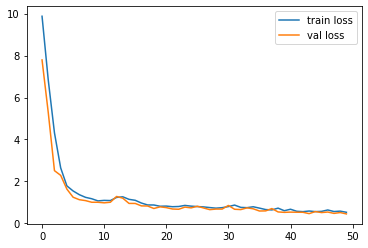

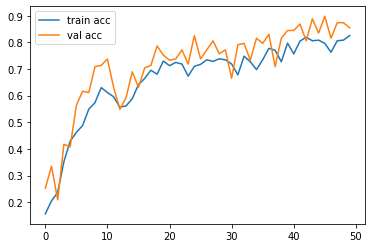

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [ ]:
y_pred = model.predict(test_set)

3/3 [==============================] - 2s 315ms/step


In [ ]:
y_pred

array([[1.3703982e-04, 2.5808849e-04, 2.1044300e-03, ..., 6.7861509e-03,
        4.1321814e-03, 6.1578747e-02],
       [8.1933793e-03, 1.7034668e-02, 1.7130502e-01, ..., 5.8597486e-02,
        2.2648090e-01, 2.2242464e-01],
       [1.2689388e-02, 6.9078435e-03, 2.7356301e-02, ..., 3.4356579e-01,
        3.6103483e-03, 4.1722789e-01],
       ...,
       [4.5697390e-05, 6.6127000e-06, 5.4567814e-04, ..., 9.9439275e-01,
        1.5957267e-03, 1.0004619e-03],
       [4.2419117e-11, 1.5026204e-11, 1.5330956e-04, ..., 9.9983311e-01,
        1.3347445e-10, 2.7340874e-07],
       [9.9304056e-01, 1.7677394e-03, 1.0987370e-03, ..., 1.9586210e-03,
        1.5612562e-04, 1.2609054e-03]], dtype=float32)

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([3, 3, 7, 3, 7, 7, 3, 3, 3, 7, 7, 3, 7, 3, 0, 7, 3, 5, 7, 2, 3, 7,
       0, 0, 5, 4, 7, 7, 3, 7, 3, 3, 5, 5, 0, 7, 4, 3, 7, 2, 6, 7, 5, 3,
       3, 1, 0, 3, 7, 7, 7, 7, 3, 4, 1, 3, 2, 4, 3, 7, 3, 7, 0, 3, 5, 5,
       3, 3, 0, 7, 0, 4, 4, 3, 7, 1, 3, 4, 5, 5, 0, 1, 2, 3, 3, 3, 3, 7,
       3, 5, 0, 3, 3, 0, 3, 1, 3, 7, 3, 7, 3, 3, 7, 7, 3, 5, 3, 7, 0, 5,
       0, 4, 5, 5, 7, 7, 4, 0, 6, 5, 3, 2, 4, 7, 2, 1, 2, 3, 7, 4, 3, 2,
       0, 7, 6, 3, 6, 6, 0, 6, 5, 7, 4, 2, 6, 2, 5, 7, 1, 0, 2, 3, 7, 3,
       5, 6, 3, 3, 2, 6, 3, 6, 5, 3, 3, 7, 3, 7, 5, 3, 4, 3, 7, 6, 2, 5,
       5, 3, 4, 0, 2, 5, 0, 4, 3, 0, 5, 2, 6, 0, 7, 3, 4, 0, 7, 1, 3, 4,
       3, 3, 5, 7, 0, 5, 5, 0])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model_resnet50.h5')

In [ ]:
img_data

NameError: ignored